# Network Analysis for Information Retrieval - Part 3

Elyes KHALFALLAH & Mohammed ali EL ADLOUNI

16/03/2025

---

---


## Exercice 7 : Prise en compte de la structure du corpus


In [1]:
# Useful libraries
from fonctions import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import networkx as nx
import ipysigma as sigma
import random
import community.community_louvain as community_louvain
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.linalg import eigh


In [2]:
# Load data
data_text = pd.read_csv("data_text.csv")
print(data_text.shape)

data_text.info()


(40596, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40596 entries, 0 to 40595
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        36172 non-null  object
 1   venue       40596 non-null  object
 2   abstract    18013 non-null  object
 3   authors     40596 non-null  object
 4   n_citation  40596 non-null  int64 
 5   references  27246 non-null  object
 6   title       40596 non-null  object
 7   year        40596 non-null  int64 
 8   id          40596 non-null  object
 9   class       40596 non-null  int64 
dtypes: int64(3), object(7)
memory usage: 3.1+ MB


In [3]:
data_text.head()


,text,venue,abstract,authors,n_citation,references,title,year,id,class
0,comprehension school mind school studying col,international conference on human-computer int...,The purpose of this study is to develop a lear...,"['Makoto Satoh', 'Ryo Muramatsu', 'Mizue Kayam...",0,"['51c7e02e-f5ed-431a-8cf5-f761f266d4be', '69b6...",Preliminary Design of a Network Protocol Learn...,2013,00127ee2-cb05-48ce-bc49-9de556b93346,3
1,physically visualisation roman visualisation h...,visual analytics science and technology,This paper describes the design and implementa...,"['Gareth Beale', 'Graeme Earl']",50,"['10482dd3-4642-4193-842f-85f3b70fcf65', '3133...",A methodology for the physically accurate visu...,2011,001c58d3-26ad-46b3-ab3a-c1e557d16821,3
2,financial ar arma bp forecasting international...,pattern recognition and machine intelligence,This article applied GARCH model instead AR or...,"['Altaf Hossain', 'Faisal Zaman', 'Mohammed Na...",50,"['2d84c0f2-e656-4ce7-b018-90eda1c132fe', 'a083...","Comparison of GARCH, Neural Network and Suppor...",2009,001c8744-73c4-4b04-9364-22d31a10dbf1,4
3,simplify,international conference on computer graphics ...,NaN,"['Rafael Álvarez', 'Leandro Tortosa', 'José-Fr...",0,NaN,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,2009,005ce28f-ed77-4e97-afdc-a296137186a1,5
4,secret,international symposium on computer and inform...,NaN,"['Guzin Ulutas', 'Mustafa Ulutas', 'Vasif V. N...",0,"['5626736c-e434-4e2d-8405-54940fab88ab', '8e87...",Improved Secret Image Sharing Method By Encodi...,2011,00701b05-684f-45f9-b281-425abfec482c,8


---

## 7.1. : Matrice d'adjacence


In [4]:
# Factorize the 'venue' column to get numeric codes
# n : number of documents
# unique_venues : list of unique venues


venue_codes, unique_venues = pd.factorize(data_text["venue"])


print(f"{len(venue_codes)   = }")


print(f"{len(unique_venues) = }")


print(f"{venue_codes = }\n")
print(len(unique_venues))


n_articles = len(data_text)
print(f"{n_articles = }")


len(venue_codes)   = 40596
len(unique_venues) = 1701
venue_codes = array([  0,   1,   2, ...,  45, 566, 879], shape=(40596,))

1701
n_articles = 40596


In [5]:
# Create a sparse indicator matrix: each article (row) gets a 1 at its venue (column)
data = np.ones(n_articles, dtype=int)
row_indices = np.arange(n_articles)
col_indices = venue_codes

# Build the sparse matrix (shape: [n_articles x n_unique_venues])
M = csr_matrix(
    (data, (row_indices, col_indices)), shape=(n_articles, len(unique_venues))
)

# Compute the adjacency matrix as the dot product of M with its transpose
# Each off-diagonal entry is 1 if the two articles share the same venue; diagonal entries are 1 as well.
adjacency_matrix = M.dot(M.T)

# If needed, convert to a dense NumPy array (note: this might be memory intensive for large n)
# adjacency_dense = adjacency_matrix.toarray()


In [6]:
print(adjacency_matrix.shape)
# print(adjacency_matrix)


(40596, 40596)


---

## 7.2. : Creation et statistiques du graphe


In [7]:
# Convert the sparse adjacency matrix to a NetworkX graph.
# Each node corresponds to an article.
G = nx.from_scipy_sparse_array(adjacency_matrix)


In [8]:
# --- Degree Distribution ---
# Get degrees of all nodes.
degrees = [degree for node, degree in G.degree()]

# Compute a histogram of degrees.
hist, bin_edges = np.histogram(degrees, bins=range(max(degrees) + 2))

# print("Degree Distribution:")
# for deg, count in zip(bin_edges[:-1], hist):
#     print(f"Degree {deg:4.0f}: {count} nodes")

# # Optionally, plot the degree distribution.
# plt.figure(figsize=(8, 5))
# plt.bar(bin_edges[:-1], hist, width=0.8, align="center")
# plt.xlabel("Degree")
# plt.ylabel("Number of Nodes")
# plt.title("Degree Distribution")
# plt.show()


In [9]:
# --- Graph Density ---
density = nx.density(G)
print("Graph Density:", density)


Graph Density: 0.006825693399411704


In [10]:
# --- Graph Width ---
# Here, 'width' can be interpreted in a couple of ways.
# For example, you might consider the maximum degree as a measure of the graph's width.
max_degree = max(degrees)
print("Graph Width (Maximum Degree):", max_degree)


Graph Width (Maximum Degree): 2316


In [11]:
# --- Graph Diameter ---
# Note: The diameter is defined only for connected graphs.
# If the graph is disconnected, you can compute the diameter of each connected component.
if nx.is_connected(G):
    diameter = nx.diameter(G)
    print("Graph Diameter:", diameter)
else:
    # Compute diameters for each connected component (ignoring isolated nodes)
    components = [
        G.subgraph(c).copy() for c in nx.connected_components(G) if len(c) > 1
    ]
    diameters = [nx.diameter(comp) for comp in components]
    print("Graph is not fully connected. Diameters of connected components:", diameters)


Graph is not fully connected. Diameters of connected components: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [12]:
# # --- Clustering Coefficients ---
# # Compute the clustering coefficient for each node.
# clustering_coeffs = nx.clustering(G)
# # Calculate the average clustering coefficient.
# avg_clustering = np.mean(list(clustering_coeffs.values()))
# print("Average Clustering Coefficient:", avg_clustering)


---

## 7.3. : Visualisation du graphe


In [13]:
# Step 1: Add Node Attributes
for i, row in data_text.iterrows():
    # Here, we use the 'class' column as the dominant theme.
    G.nodes[i]["theme"] = row["class"]
    # Optionally, you can add a label (like the article title) to make the visualization more informative:
    G.nodes[i]["label"] = row["title"]


In [14]:
# Step 2: Map Themes to Colors
# Collect all unique themes.
themes = [G.nodes[n]["theme"] for n in G.nodes()]
unique_themes = sorted(set(themes))
print("Unique Themes:", unique_themes)

# Create a colormap using matplotlib's rainbow.
cmap = cm.get_cmap("rainbow", len(unique_themes))
theme_color_mapping = {
    theme: mcolors.rgb2hex(cmap(i)) for i, theme in enumerate(unique_themes)
}

# Assign a color attribute to each node based on its theme.
for n_articles in G.nodes():
    theme = G.nodes[n_articles]["theme"]

    # default color if theme not found
    G.nodes[n_articles]["color"] = theme_color_mapping.get(theme, "#cccccc")


Unique Themes: [1, 2, 3, 4, 5, 6, 7, 8]


C:\Users\elyes\AppData\Local\Temp\ipykernel_16700\2961599380.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_themes))


In [15]:
random.seed(42)  # Set random seed for reproducibility

# Sample a subset of nodes
sample_size = 2500
sample_nodes = random.sample(list(G.nodes()), sample_size)

G_sub = G.subgraph(sample_nodes)  # Create a subgraph from the sampled nodes

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
# vis


---

## 7.4. : Clustering


### Louvain


In [16]:
# Run the Louvain algorithm on your graph G
# This returns a dictionary mapping each node to its detected community.
partition = community_louvain.best_partition(G)

# Add the computed cluster to each node's attributes in the graph.
for node, cluster in partition.items():
    G.nodes[node]["louvain_cluster"] = cluster

# Add the cluster information to the dataframe
data_text["louvain_cluster"] = data_text.index.map(lambda i: partition[i])

num_clusters = len(set(partition.values()))
print(f"Louvain detected {num_clusters} clusters.")


Louvain detected 1701 clusters.


### Spectral


In [17]:
# Set random seed for reproducibility
random.seed(42)

# Randomly select a subset of nodes from the graph
sample_nodes = random.sample(list(G.nodes()), 10000)

# Create a subgraph from the sampled nodes
G_sub_spectral = G.subgraph(sample_nodes)

# Convert the subgraph to an adjacency matrix
adj_matrix = nx.to_numpy_array(G_sub_spectral)

# Perform spectral clustering
spectral = SpectralClustering(n_clusters=8, affinity="precomputed", random_state=42)
spectral_labels = spectral.fit_predict(adj_matrix)

# Add the computed cluster to each node's attributes in the graph
for node, cluster in zip(sample_nodes, spectral_labels):
    G.nodes[node]["spectral_cluster"] = cluster

# Add the cluster information to the dataframe
data_text["spectral_cluster"] = data_text.index.map(
    lambda i: G.nodes[i].get("spectral_cluster")
)

num_clusters = len(set(spectral_labels))
print(f"Spectral detected {num_clusters} clusters.")


c:\Users\elyes\Desktop\MALIA\NetworkAnalysis_SearchEngine\env_netanalysis\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Spectral detected 8 clusters.


In [18]:
# Set random seed for reproducibility
random.seed(42)

# Create a color mapping for all Louvain clusters.
# Collect all unique themes.
louvain_themes = [G.nodes[n]["louvain_cluster"] for n in G.nodes()]
unique_louvain_themes = sorted(set(louvain_themes))
print("Unique Themes:", unique_louvain_themes)

# Create a colormap using matplotlib's rainbow.
cmap = cm.get_cmap("rainbow", len(unique_louvain_themes))
louvain_theme_color_mapping = {
    theme: mcolors.rgb2hex(cmap(i)) for i, theme in enumerate(unique_louvain_themes)
}

# Assign a color attribute to each node based on its louvain_cluster.
for n in G.nodes():
    theme = G.nodes[n]["louvain_cluster"]
    G.nodes[n]["color"] = louvain_theme_color_mapping.get(theme, "#cccccc")


# Visualisation
# Set random seed for reproducibility
random.seed(42)

# Sample a subset of nodes
sample_size = 2500
sample_nodes = random.sample(list(G_sub_spectral.nodes()), sample_size)
G_sub = G.subgraph(sample_nodes)

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
# vis


Unique Themes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,

C:\Users\elyes\AppData\Local\Temp\ipykernel_16700\4087324532.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_louvain_themes))


In [19]:
# Set random seed for reproducibility
random.seed(42)

# Create a color mapping for all Spectral clusters.
# Collect all unique themes.
spectral_themes = [
    G_sub_spectral.nodes[n]["spectral_cluster"] for n in G_sub_spectral.nodes()
]
unique_spectral_themes = sorted(set(spectral_themes))
print("Unique Themes:", unique_spectral_themes)

# Create a colormap using matplotlib's rainbow.
cmap = cm.get_cmap("rainbow", len(unique_spectral_themes))
spectral_theme_color_mapping = {
    theme: mcolors.rgb2hex(cmap(i)) for i, theme in enumerate(unique_spectral_themes)
}

# Assign a color attribute to each node based on its spectral_cluster.
for n in G_sub_spectral.nodes():
    theme = G_sub_spectral.nodes[n]["spectral_cluster"]
    G_sub_spectral.nodes[n]["color"] = spectral_theme_color_mapping.get(
        theme, "#cccccc"
    )


# Visualisation
# Set random seed for reproducibility
random.seed(42)

# Sample a subset of nodes
sample_size = 2500
sample_nodes = random.sample(list(G_sub_spectral.nodes()), sample_size)
G_sub = G.subgraph(sample_nodes)

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
# vis


Unique Themes: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7)]


C:\Users\elyes\AppData\Local\Temp\ipykernel_16700\3696496144.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("rainbow", len(unique_spectral_themes))


---

## 7.5. : Calcul de représentations sur le graph avec Laplacian Eigenmaps


In [20]:
# Calcul des similarités sur les arêtes (ici, un exemple simple d'weights)
for u, v in G_sub.edges():
    G_sub[u][v]["weight"] = np.random.rand()  # Poids aléatoires pour chaque arête

# 2. Calcul du Laplacien
A = nx.adjacency_matrix(G_sub).toarray()  # Matrice d'adjacence
degrees = np.sum(A, axis=1)  # Degré de chaque noeud
D = np.diag(degrees)  # Matrice des degrés

# Laplacien
L = D - A

# 3. Calcul des valeurs et vecteurs propres
# On résout le problème aux valeurs propres pour obtenir les vecteurs de l'espace réduit
# Note: Ne prendre que les k plus petites valeurs propres (ici k=2)
eigenvalues, eigenvectors = eigh(L)

# Sélectionner les k premières valeurs propres et leurs vecteurs associés
k = 2
embedding = eigenvectors[:, :k]  # Embedding de dimension 2 (puisque k=2)


ValueError: 'c' argument has 40596 elements, which is inconsistent with 'x' and 'y' with size 2500.

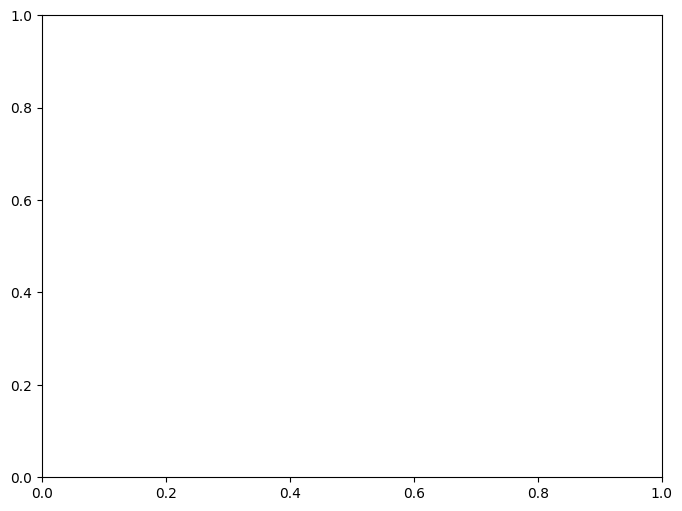

In [21]:
# 4. Visualisation de l'Embedding obtenu via Laplacian Eigenmaps
plt.figure(figsize=(8, 6))

# Ensure the color array has the same number of nodes as the embedding
node_colors = np.arange(len(G.nodes()))  # This should match the number of nodes in the embedding

# If the number of nodes is mismatched, ensure they are consistent with the embedding size
if len(node_colors) != len(embedding):
    print(f"Warning: Size mismatch! Nodes: {len(node_colors)}, Embedding: {len(embedding)}")
    node_colors = np.arange(len(embedding))  # Adjust node_colors to match the embedding size

# Now plot the scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1], c=node_colors, cmap="viridis")
plt.title("Projection via Laplacian Eigenmaps")
plt.colorbar(label="Node index")
plt.show()


In [ ]:
# 5. Comparaison avec une visualisation du graphe
# Ici, on utilise un layout de type "spring layout" pour comparer
pos = nx.spring_layout(G)  # Positionnement des noeuds basé sur la force des arêtes

plt.figure(figsize=(8, 6))
nx.draw(
    G_sub,
    pos,
    with_labels=True,
    node_color=np.arange(len(G.nodes())),
    cmap="rainbow",
    node_size=500,
)
plt.title("Visualisation du graphe avec spring layout")
plt.show()


In [ ]:
# 6. Optionnel : projection de l'Embedding avec t-SNE ou PCA
# Comparer en projetant l'Embedding obtenu par Laplacian Eigenmaps avec t-SNE
embedding_tsne = TSNE(n_components=2).fit_transform(embedding)

plt.figure(figsize=(8, 6))
plt.scatter(
    embedding_tsne[:, 0],
    embedding_tsne[:, 1],
    c=np.arange(len(G.nodes())),
    cmap="rainbow",
)
plt.title("Projection via t-SNE")
plt.colorbar(label="Node index")
plt.show()


In [ ]:
# Define the vectorizer
tf_vectorizer = TfidfVectorizer(use_idf=False)

data_text_ = data_text.dropna(subset=["text"])
print(data_text.shape)

# Fit and transform the vectorizer on the 'text' column
X_tf = tf_vectorizer.fit_transform(data_text_["text"])

# Show the shape of the resulting matrix
X_tf.shape


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 8
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
X_topics = lda_model.fit_transform(X_tf)


In [ ]:
# Assuming X_topics is the result of your LDA model (shape: [n_articles, num_topics])
# and that df is your DataFrame
dominant_topic = X_topics.argmax(axis=1)
data_text_["dominant_topic"] = dominant_topic


In [ ]:
import networkx as nx
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Assume G is the NetworkX graph built from your articles (nodes 0 to n-1)
# and the order of the DataFrame matches the graph's node order.
for i, row in data_text_.iterrows():
    # Set the dominant topic as the theme
    G.nodes[i]["theme"] = row["dominant_topic"]
    # Optionally, avoid heavy labels by not setting a verbose label.
    # For instance, you could simply keep a minimal label:
    # G.nodes[i]['label'] = f"Topic {row['dominant_topic']}"

# Map each unique topic to a color
unique_topics = sorted(set(data_text_["dominant_topic"]))
cmap = cm.get_cmap("tab10", len(unique_topics))
topic_color_mapping = {
    topic: mcolors.rgb2hex(cmap(i)) for i, topic in enumerate(unique_topics)
}

# Assign the corresponding color to each node
for n_articles in G.nodes():
    topic = G.nodes[n_articles]["theme"]
    G.nodes[n_articles]["color"] = topic_color_mapping.get(topic, "#cccccc")


In [ ]:
# Sample a subset of nodes (e.g., 500 nodes)
sample_size = 250  # Adjust this number based on performance
sample_nodes = random.sample(list(G.nodes()), sample_size)
G_sub = G.subgraph(sample_nodes)

# Visualize the subgraph
vis = sigma.Sigma(G_sub)
# vis


In [ ]:
import community as community_louvain
import networkx as nx

# Run the Louvain algorithm on your graph G
# This returns a dictionary mapping each node to its detected community.
partition = community_louvain.best_partition(G)

# Add the computed cluster to each node's attributes in the graph.
for node, cluster in partition.items():
    G.nodes[node]["cluster"] = cluster

# Optionally, add the cluster information to your DataFrame.
data_text["cluster"] = data_text.index.map(lambda i: partition[i])


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Get unique clusters detected by Louvain.
unique_clusters = sorted(set(partition.values()))

# Create a colormap (here, 'tab20' is used, which gives up to 20 distinct colors).
cmap = cm.get_cmap("tab20", len(unique_clusters))
cluster_color_mapping = {
    cluster: mcolors.rgb2hex(cmap(i)) for i, cluster in enumerate(unique_clusters)
}

# Update each node with its corresponding color.
for node in G.nodes():
    G.nodes[node]["color"] = cluster_color_mapping[G.nodes[node]["cluster"]]


In [ ]:
import random
import ipysigma as sigma

# Define the sample size
sample_size = 250  # adjust as needed

# Randomly select a subset of nodes from the graph
sample_nodes = random.sample(list(G.nodes()), sample_size)

# Create a subgraph from the sampled nodes. .copy() ensures you have an independent graph object.
G_sub = G.subgraph(sample_nodes).copy()

# Visualize the subgraph using ipysigma
vis = sigma.Sigma(G_sub)
# vis


In [ ]:
from karateclub import DeepWalk
import networkx as nx

# Assume G_sub is your subgraph (a NetworkX graph)
# Create and configure the DeepWalk model
deepwalk_model = DeepWalk(dimensions=64, walk_number=200, walk_length=30, workers=4)

# Fit the model on your graph
deepwalk_model.fit(G_sub)

# Get the node embeddings (rows correspond to nodes in the same order as G_sub.nodes())
embeddings = deepwalk_model.get_embedding()


In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the projected embeddings
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=20, c="blue", alpha=0.7)
plt.title("t-SNE Projection of Node2Vec Embeddings")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.show()
